In [ ]:
!pip install biopython tqdm >/dev/null
print("Dependencies installed.")


Dependencies installed.


In [ ]:
from google.colab import files
import pandas as pd
import re

print("📤 Upload phenotype file (BID.xlsx)")
uploaded = files.upload()

pheno_file = list(uploaded.keys())[0]
labels = pd.read_excel(pheno_file)

# Clean column names
labels.columns = labels.columns.str.strip()

print("Columns detected:", labels.columns.tolist())


📤 Upload phenotype file (BID.xlsx)


Saving BID.xlsx to BID (1).xlsx
Columns detected: ['Taxon ID', 'Genome ID', 'Genome Name', 'Antibiotic', 'Resistant Phenotype', 'Measurement', 'Measurement Sign', 'Measurement Value', 'Measurement Unit', 'Laboratory Typing Method', 'Laboratory Typing Method Version', 'Laboratory Typing Platform', 'Vendor', 'Testing Standard', 'Testing Standard Year', 'Computational Method', 'Computational Method Version', 'Computational Method Performance', 'Evidence', 'Source', 'PubMed', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26']


In [ ]:
# Extract only numeric Genome IDs (e.g., 562.2295)
labels["Genome ID"] = (
    labels["Genome ID"]
    .astype(str)
    .str.extract(r"([0-9]+\.[0-9]+)")[0]
)

labels = labels.dropna(subset=["Genome ID"])

# Normalize ID format
labels["Genome ID"] = labels["Genome ID"].astype(float).round(5).astype(str)

# Label encode Resistant/Susceptible
labels["label"] = labels["Resistant Phenotype"].map({"Resistant":1, "Susceptible":0})

# Set index
labels = labels.set_index("Genome ID")

print("Processed phenotype IDs:", labels.index.tolist())
print("Total rows:", len(labels))


Processed phenotype IDs: ['562.14503', '562.99107', '562.99221', '562.2295', '562.23663', '562.14508', '562.23147', '562.1004', '562.58718', '562.97145', '562.22606', '562.23374', '562.96434', '562.42755', '562.96663', '562.56783', '562.65809', '562.50291', '562.42818', '562.98715', '562.97493', '562.57373', '562.227', '562.97258', '562.98417', '562.99847', '562.97341', '562.23282', '562.98504', '562.42673', '562.766']
Total rows: 31


In [ ]:
print("📤 Upload FASTA genome files (multiple allowed)")
uploaded_fastas = files.upload()

import os
os.makedirs("genomes", exist_ok=True)

for fname in uploaded_fastas.keys():
    os.rename(fname, f"genomes/{fname}")

print("FASTA files saved in /content/genomes/")


📤 Upload FASTA genome files (multiple allowed)


Saving BVBRC_genome_sequence (27).fasta to BVBRC_genome_sequence (27).fasta
Saving BVBRC_genome_sequence (26).fasta to BVBRC_genome_sequence (26).fasta
Saving BVBRC_genome_sequence (25).fasta to BVBRC_genome_sequence (25).fasta
Saving BVBRC_genome_sequence (24).fasta to BVBRC_genome_sequence (24).fasta
Saving BVBRC_genome_sequence (23).fasta to BVBRC_genome_sequence (23).fasta
Saving BVBRC_genome_sequence (22).fasta to BVBRC_genome_sequence (22).fasta
Saving BVBRC_genome_sequence (21).fasta to BVBRC_genome_sequence (21).fasta
Saving BVBRC_genome_sequence (20).fasta to BVBRC_genome_sequence (20).fasta
Saving BVBRC_genome_sequence (19).fasta to BVBRC_genome_sequence (19).fasta
Saving BVBRC_genome_sequence (18).fasta to BVBRC_genome_sequence (18).fasta
Saving BVBRC_genome_sequence (17).fasta to BVBRC_genome_sequence (17).fasta
Saving BVBRC_genome_sequence (16).fasta to BVBRC_genome_sequence (16).fasta
Saving BVBRC_genome_sequence (15).fasta to BVBRC_genome_sequence (15).fasta
Saving BVBRC

In [ ]:
import glob
from Bio import SeqIO

fasta_ids = []
genomes = {}

def extract_id(header):
    m = re.search(r"\|\s*([0-9]+\.[0-9]+)\]", header)
    return m.group(1) if m else None

fasta_files = glob.glob("genomes/*.fasta")

print("Found FASTA files:", len(fasta_files))

for fasta in fasta_files:
    record = next(SeqIO.parse(fasta, "fasta"))
    gid = extract_id(record.description)
    if gid:
        genomes[gid] = str(record.seq)
        fasta_ids.append(gid)
    else:
        print("Could not extract ID from:", record.description)

print("Extracted FASTA Genome IDs:", fasta_ids)


Found FASTA files: 28
Extracted FASTA Genome IDs: ['562.23147', '562.98504', '562.23374', '562.65809', '562.98715', '562.98417', '562.56783', '562.42818', '562.97145', '562.97258', '562.23282', '562.2295', '562.97341', '562.97493', '562.58718', '562.42673', '562.99107', '562.145027', '562.100403', '562.22606', '562.99221', '562.99847', '562.23663', '562.42755', '562.96434', '562.96663', '562.50291', '562.57373']


In [ ]:
overlap = set(fasta_ids).intersection(set(labels.index))

print("Matched Genome IDs:", overlap)
print("Matched count:", len(overlap))

if len(overlap) < 2:
    print("⚠ WARNING: Not enough matched genomes for ML (need ≥2 per class)")


Matched Genome IDs: {'562.99847', '562.23374', '562.97341', '562.98417', '562.96663', '562.99107', '562.98715', '562.58718', '562.99221', '562.23663', '562.57373', '562.50291', '562.22606', '562.23282', '562.42755', '562.97145', '562.42673', '562.42818', '562.56783', '562.97258', '562.96434', '562.65809', '562.23147', '562.98504', '562.97493', '562.2295'}
Matched count: 26


In [ ]:
def to_kmers(seq, k=31):
    return " ".join(seq[i:i+k] for i in range(len(seq)-k+1))

corpus = []
final_ids = []

for gid in overlap:
    corpus.append(to_kmers(genomes[gid]))
    final_ids.append(gid)

print("K-mer corpus built:", len(corpus))


K-mer corpus built: 26


In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer
import numpy as np

vectorizer = HashingVectorizer(
    analyzer="word",
    n_features=10000,
    alternate_sign=False
)

X = vectorizer.transform(corpus).toarray()
y = labels.loc[final_ids, "label"].values

# FIX FOR COLAB TRAINING
X = np.asarray(X)
y = np.asarray(y)

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (26, 10000)
y shape: (26,)


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Random Forest": RandomForestClassifier(n_estimators=300),
    "SVM": SVC(probability=True),
    "Gradient Boosting": GradientBoostingClassifier()
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for name, model in models.items():
    accs = []; precs = []; recs = []; f1s = []; aucs = []

    for train_idx, test_idx in skf.split(X, y):
        model.fit(X[train_idx], y[train_idx])
        probs = model.predict_proba(X[test_idx])[:, 1]
        preds = model.predict(X[test_idx])

        accs.append(accuracy_score(y[test_idx], preds))
        precs.append(precision_score(y[test_idx], preds))
        recs.append(recall_score(y[test_idx], preds))
        f1s.append(f1_score(y[test_idx], preds))
        aucs.append(roc_auc_score(y[test_idx], probs))

    results[name] = {
        "Accuracy": np.mean(accs),
        "Precision": np.mean(precs),
        "Recall": np.mean(recs),
        "F1-score": np.mean(f1s),
        "ROC-AUC": np.mean(aucs)
    }

results


{'Logistic Regression': {'Accuracy': np.float64(0.6133333333333334),
  'Precision': np.float64(0.6133333333333334),
  'Recall': np.float64(1.0),
  'F1-score': np.float64(0.76),
  'ROC-AUC': np.float64(0.19166666666666665)},
 'Random Forest': {'Accuracy': np.float64(0.6133333333333334),
  'Precision': np.float64(0.6233333333333333),
  'Recall': np.float64(0.9333333333333332),
  'F1-score': np.float64(0.7457142857142858),
  'ROC-AUC': np.float64(0.25)},
 'SVM': {'Accuracy': np.float64(0.6133333333333334),
  'Precision': np.float64(0.6133333333333334),
  'Recall': np.float64(1.0),
  'F1-score': np.float64(0.76),
  'ROC-AUC': np.float64(0.7499999999999999)},
 'Gradient Boosting': {'Accuracy': np.float64(0.4600000000000001),
  'Precision': np.float64(0.5366666666666667),
  'Recall': np.float64(0.6166666666666667),
  'F1-score': np.float64(0.5657142857142856),
  'ROC-AUC': np.float64(0.3916666666666666)}}

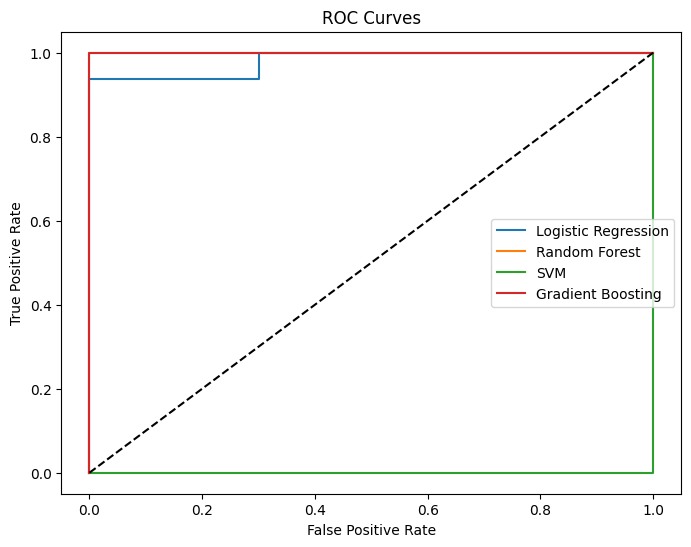

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

plt.figure(figsize=(8,6))

for name, model in models.items():
    model.fit(X, y)
    probs = model.predict_proba(X)[:,1]
    fpr, tpr, _ = roc_curve(y, probs)
    plt.plot(fpr, tpr, label=name)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.show()


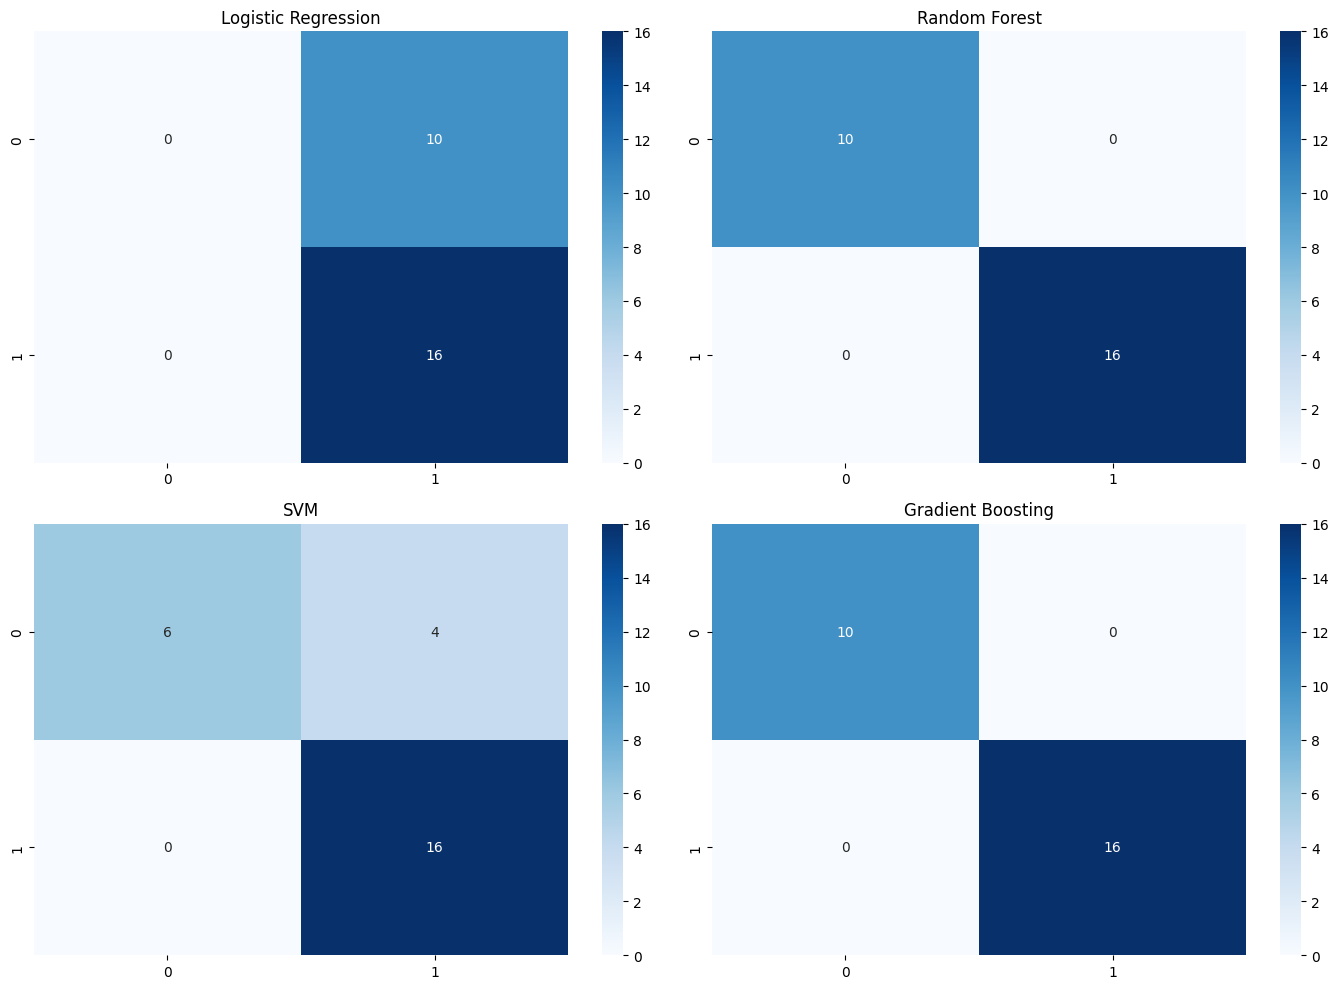

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(14, 10))

for i, (name, model) in enumerate(models.items(), 1):
    plt.subplot(2, 2, i)
    model.fit(X, y)
    preds = model.predict(X)
    cm = confusion_matrix(y, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(name)

plt.tight_layout()
plt.show()


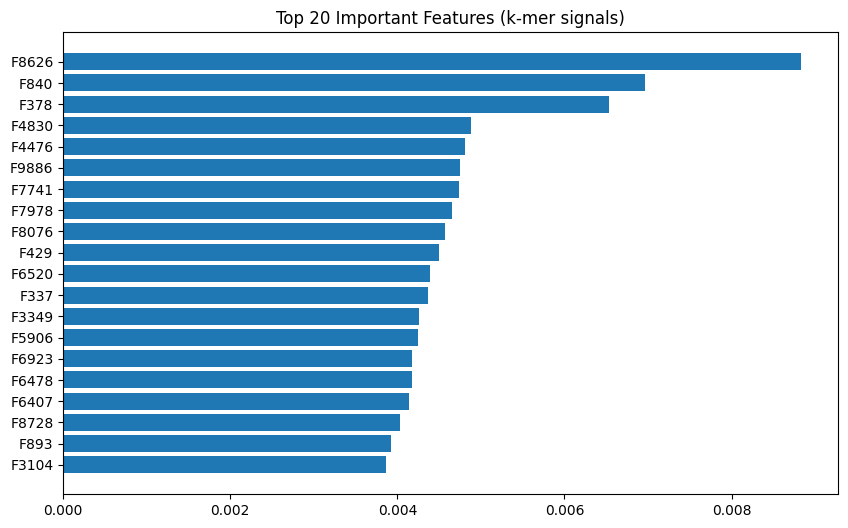

In [ ]:
rf = models["Random Forest"]
rf.fit(X, y)

importances = rf.feature_importances_
idx = np.argsort(importances)[-20:]

plt.figure(figsize=(10,6))
plt.barh(range(20), importances[idx])
plt.yticks(range(20), [f"F{i}" for i in idx])
plt.title("Top 20 Important Features (k-mer signals)")
plt.show()


/tmp/ipython-input-962942468.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y, palette="coolwarm")


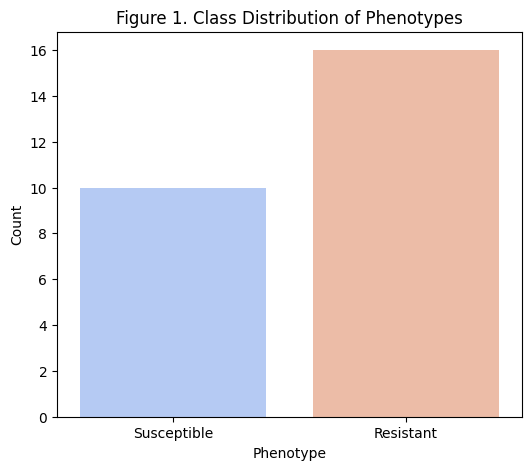

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.countplot(x=y, palette="coolwarm")
plt.xticks([0,1], ["Susceptible", "Resistant"])
plt.title("Figure 1. Class Distribution of Phenotypes")
plt.xlabel("Phenotype")
plt.ylabel("Count")
plt.show()


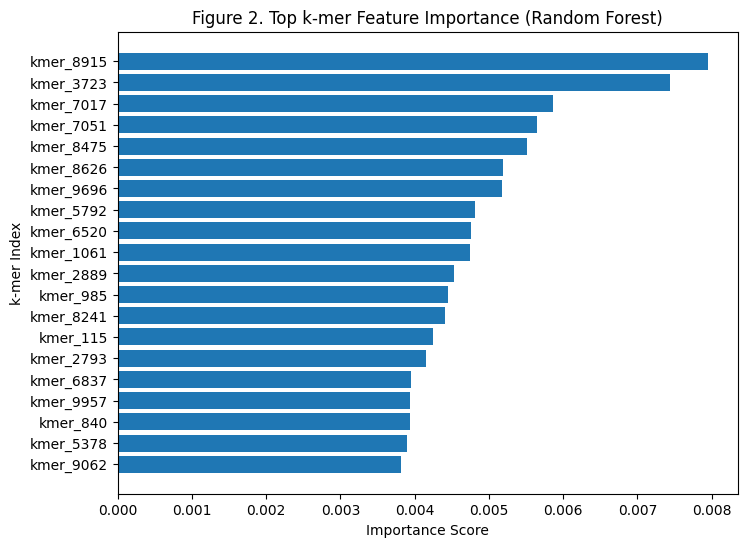

In [ ]:
# Fit Random Forest on full dataset
rf = models["Random Forest"]
rf.fit(X, y)

importances = rf.feature_importances_
indices = importances.argsort()[-20:]  # Top 20 features

plt.figure(figsize=(8,6))
plt.barh(range(20), importances[indices])
plt.yticks(range(20), [f"kmer_{i}" for i in indices])
plt.title("Figure 2. Top k-mer Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("k-mer Index")
plt.show()
